<a href="https://colab.research.google.com/github/marlenebauer/Deep_learning/blob/main/ParkingLotDetection_allModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Submission for Deep Learning (04-GEO-MET4)
**Authors:** Christina, Krause, Marlene Bauer, Anna Bischof

**Lecturer:** Jakob Schwalb-Willman

**Submission Date:** 30th of September 2024
## Parking Lot detection in Würzburg, Germany
----

### Problem Statement
Something aboout the Releveance of our work

## Set up

In [ ]:
!pip install --upgrade keras

In [ ]:
# Install the following libraries
import numpy as np
import keras
from keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_datasets as tfdatasets
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from keras import ops

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ensure that the google drive folder with the dataset supplied by us is connected to a folder in your drive ("Verknüpfung herstellen"). Click on the shared folder and press Ctrl Alt R to add a connection to your drive.

## Dataset preperation

In [ ]:
# ADJUST PATHS
raster_folder= '/content/drive/MyDrive/EAGLE/DL_task/rasters_filtered_above_zero_matching'
mask_folder= '/content/drive/MyDrive/EAGLE/DL_task/maks_filtered_new_try'

raster_paths = sorted(glob.glob(raster_folder+'/*.npy'))
mask_paths = sorted(glob.glob(mask_folder+'/*.npy'))

print(len(raster_paths))
print(len(mask_paths))

8260
8260


In [ ]:
data = np.column_stack((raster_paths, mask_paths))

In [ ]:
len(data)

8260

In [ ]:
data[0, ]

array(['/content/drive/MyDrive/EAGLE/DL_task/rasters_filtered_above_zero_matching/32562_5513_raster_tile_0_1650.npy',
       '/content/drive/MyDrive/EAGLE/DL_task/maks_filtered_new_try/32562_5513_mask_tile_0_1650.npy'],
      dtype='<U110')

In [ ]:
np.random.seed(5) # set seed to ensure reproducability
np.random.shuffle(data)
data[0,]

array(['/content/drive/MyDrive/EAGLE/DL_task/rasters_filtered_above_zero_matching/32571_5516_raster_tile_2250_1100.npy',
       '/content/drive/MyDrive/EAGLE/DL_task/maks_filtered_new_try/32571_5516_mask_tile_2250_1100.npy'],
      dtype='<U110')

In [ ]:
# Split in train, val and test
prop_train = 0.70 # 70% for training
prop_val = 0.15 #15% for validation -> 15% for testing

# compute the split indices
train_idx= int(prop_train * len(data))
val_idx= int((prop_train+prop_val)*len(data))

# Split the data
training, validation, testing = np.split(data, [train_idx, val_idx])

# Check training[0]
training[0,]

array(['/content/drive/MyDrive/EAGLE/DL_task/rasters_filtered_above_zero_matching/32571_5516_raster_tile_2250_1100.npy',
       '/content/drive/MyDrive/EAGLE/DL_task/maks_filtered_new_try/32571_5516_mask_tile_2250_1100.npy'],
      dtype='<U110')

In [ ]:
# Check the length
print(len(training))
print(len(validation))
print(len(testing))

5782
1239
1239


In [ ]:
# Set up tensor for data
train_ds = tf.data.Dataset.from_tensor_slices((training[:,0], training[:,1]))

Set up the data loader, all our tiles are saved as .npy. Since they are not saved as jpeg there is no need to decode the images. However, the shape needs to be specifically set to match our model input.

In [ ]:
# Function to load .npy files
def load_npy_files(raster_path, mask_path):
    raster = np.load(raster_path.numpy().decode('utf-8'))
    raster = np.transpose(raster, (1,2,0))

    mask = np.load(mask_path.numpy().decode('utf-8'))
    mask = np.expand_dims(mask, axis=-1)
    return raster, mask

# TensorFlow wrapper for loading .npy files
def load_npy_tf(raster_path, mask_path):
    raster, mask = tf.py_function(func=load_npy_files, inp=[raster_path, mask_path], Tout=[tf.float32, tf.float32])
    raster.set_shape([128, 128, 3])  # Set shape for the raster image
    mask.set_shape([128, 128, 1])
    return raster, mask

In [ ]:
train_ds = train_ds.map(load_npy_tf)

In [ ]:
# check the shape of our first element
for element in train_ds.take(1):
  print(element)

(<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[247., 244., 240.],
        [247., 244., 240.],
        [246., 242., 238.],
        ...,
        [239., 232., 229.],
        [198., 187., 190.],
        [155., 141., 148.]],

       [[247., 243., 239.],
        [246., 242., 238.],
        [247., 244., 239.],
        ...,
        [179., 168., 165.],
        [238., 230., 224.],
        [227., 218., 217.]],

       [[246., 242., 238.],
        [246., 243., 239.],
        [248., 245., 240.],
        ...,
        [150., 139., 135.],
        [235., 230., 225.],
        [253., 253., 252.]],

       ...,

       [[196., 174., 162.],
        [197., 174., 162.],
        [202., 179., 167.],
        ...,
        [107., 103.,  74.],
        [104., 102.,  72.],
        [106., 105.,  74.]],

       [[197., 174., 163.],
        [198., 174., 163.],
        [201., 177., 165.],
        ...,
        [115., 106.,  81.],
        [111., 103.,  77.],
        [105., 101.,  73.]],

       [[200., 1

In [ ]:
len(train_ds)

5782

In [ ]:
# now prepare val and test data
val_ds = tf.data.Dataset.from_tensor_slices((validation[:,0], validation[:,1]))
test_ds = tf.data.Dataset.from_tensor_slices((testing[:,0], testing[:,1]))

# load the arrays
val_ds = val_ds.map(load_npy_tf)
test_ds = test_ds.map(load_npy_tf)

In [ ]:
len(test_ds)

1239

## Data Augementation

To reduce total training tiles but still have a certain level of diversity in the data, instead of quadrupling the training data. We will double it and apply different augmentations on portions of the double

In [ ]:
def spectral_aug(img):
  img = tf.image.random_brightness(img, max_delta=0.3)
  img = tf.image.random_contrast(img, lower=0.8, upper=1.1)
  img = tf.image.random_saturation(img, lower=0.8, upper=1.1)
  # value must be within 0 and 1
  img = tf.clip_by_value(img, 0, 1)
  return img

In [ ]:
# create 3 portions of aug to apply different augmentations
portion_size = round(len(train_ds)/3) #1927

datasets=[]
for i in range(4):
  if i < 4:
    split_dataset = train_ds.skip(i*portion_size).take(portion_size)
    datasets.append(split_dataset)
  else:
    split_dataset = train_ds.skip(i*portion_size).take(len(train_ds)-(3*portion_size))
    datasets.append(split_dataset)

In [ ]:
# augmentation 1: flip left right, including random change of saturation, brightness and contrast
aug = datasets[0]
aug = aug.map(lambda x,y: (spectral_aug(x), y)) # only modifiyng img
aug = aug.map(lambda x,y: (tf.image.flip_left_right(x), tf.image.flip_left_right(y))) # flipping for both img and mask


In [ ]:
# add to train_ds
train_ds_aug = train_ds.concatenate(aug)
len(train_ds_aug)

7709

In [ ]:
# augmentation 2: flip up down, and spectral aug
aug = datasets[1]
aug = aug.map(lambda x,y: (spectral_aug(x), y))
aug = aug.map(lambda x,y: (tf.image.flip_up_down(x), tf.image.flip_up_down(y)))

In [ ]:
train_ds_aug = train_ds_aug.concatenate(aug)
len(train_ds_aug)

9636

In [ ]:
# augmentation 3: flip up down, left right and spectral augmentation
aug = datasets[2]
aug = aug.map(lambda x,y: (spectral_aug(x), y))
aug = aug.map(lambda x,y: (tf.image.flip_left_right(x), tf.image.flip_left_right(y)))
aug = aug.map(lambda x,y: (tf.image.flip_up_down(x), tf.image.flip_up_down(y)))

In [ ]:
train_ds_aug = train_ds_aug.concatenate(aug)
len(train_ds_aug) # Should be doubled to og train_ds

11563

In [ ]:
# shuffle the dataset:
train_ds = train_ds_aug.shuffle(buffer_size=2000)

### Optional: Implementation for Curriculum Learning

Trainings data is structured instead of completely randomly shuffled in a technique called Curriculum Learning. [Bengio et al (2009)](https://qmro.qmul.ac.uk/xmlui/bitstream/handle/123456789/15972/Bengio%2C%202009%20Curriculum%20Learning.pdf?sequence=1&isAllowed=y) based the concept of Curriculum Learning on the comparisons to human that learn better when examples are presented in increasing complexity. Instead of providing a random order of examples, they are meaningfully structurred. Examples that are representative and 'easy' (can be very subjective to the learning problem) are presented first followed by more complex examples.

In our set up, we decided to start training with images that are containing an above median amount of parking lot pixels (prio_data). We decided to augment these images for higher variability and to not double a single image, since these images present a protion of the already existing training dataset. We hypothesize that according to Bengio et al (2009) this approach will lead to better generalization of the model.


In [ ]:
# load high priority images
#ADJUST PATHS TO ABOVE MEDIAN IMAGES
prio_mask_folder = '/content/drive/MyDrive/EAGLE/DL_task/Training_tiles_filtered_median_testing/masks_filtered_median_testing'
prio_raster_folder = '/content/drive/MyDrive/EAGLE/DL_task/Training_tiles_filtered_median_testing/rasters_filtered_median_testing'

prio_raster_paths = sorted(glob.glob(prio_raster_folder+'/*.npy'))
prio_mask_paths = sorted(glob.glob(prio_mask_folder+'/*.npy'))

print(len(prio_raster_paths))
print(len(prio_mask_paths))

# stack the data
prio_data = np.column_stack((prio_raster_paths, prio_mask_paths))

#create data loader
prio_ds = tf.data.Dataset.from_tensor_slices((training[:,0], training[:,1]))
prio_ds = prio_ds.map(load_npy_tf)


3502
3502


In [ ]:
# apply augmentation to prio dataset
# function for random 90° rotations
def rot90(x,y):
  k = np.random.randint(1,4)
  return tf.image.rot90(x, k=k), tf.image.rot90(y, k=k)

# include rot90 in the data augmentation
aug = prio_ds
aug = aug.map(lambda x,y: rot90(x,y))  # Random 90-degree rotations
aug = aug.map(lambda x,y: (tf.image.flip_up_down(x), tf.image.flip_up_down(y)))
aug = aug.map(lambda x,y: (tf.image.flip_left_right(x), tf.image.flip_left_right(y)))
aug = aug.map(lambda x,y: (spectral_aug(x), y))

In [ ]:
# shuffle high priority data before adding to the full train_ds
aug = aug.shuffle(buffer_size= 2000)

In [ ]:
# Creating the full dataset
train_ds = aug.concatenate(train_ds)


In [ ]:
len(train_ds)

17345

### Continue data preparation for Model training  

In [ ]:
# now prepare val and test data
val_ds = tf.data.Dataset.from_tensor_slices((validation[:,0], validation[:,1]))
test_ds = tf.data.Dataset.from_tensor_slices((testing[:,0], testing[:,1]))

# load the arrays
val_ds = val_ds.map(load_npy_tf)
test_ds = test_ds.map(load_npy_tf)

In [ ]:
# batch the data
batch_size= 4 # currently very small batch size since training is not working, can be adjusted to 16 or 32 (or more depending on GPU)
input_shape= [128,128,3]
train_ds = train_ds.batch(batch_size)
val_ds= val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

## Custom Callbacks

We were inspired by [this Tutorial](https://betterprogramming.pub/4-keras-callbacks-that-will-change-the-way-you-train-ml-models-a0df2592d36b) to implement callbacks for our training. Here, we implemented *Early Stopping*, to avoid overfitting and reduce GPU usage, a *Csv Logger* to ensure that our training history is saved and can be plotted again, a *Model Checkpoint*, so that the best model is always saved even if we lose connection to the runtime and a *reduced learning rate on plateau*, so that when we do not see any improvement to the model after a certain amount of epochs the learning rate will be reduced. Important: changes to the patience of early_stopper and/or reduce_LR should always be compared to one another --> patience(early_stopper) > patience(reduced_LR).

In [ ]:
# Early Stopping
early_stopper = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

In [ ]:
# ADJUST PATH
# csv logger
traininglog_filepath='/content/drive/MyDrive/EAGLE/DL_task/DeepLab_csvlogger.csv' # adjust this to your own path and dont forget to change when training new model
csv_logger = tf.keras.callbacks.CSVLogger(
    traininglog_filepath,
    separator=',',
    append=False
)

In [ ]:
# ADJUST PATH
# ModelCheckpoint
checkpoint_filepath = '/content/drive/MyDrive/EAGLE/DL_task/DeepLab_CL.keras' # adjust this to your own path and dont forget to change when training new model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [ ]:
# Reduce Learning Rate on Plateau
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor= 0.1,
    patience=5,
    min_delta=0.0001,
    mode='auto',
    cooldown=0,
    min_lr=0

)

In [ ]:
callbacks_list= [early_stopper, checkpoint, csv_logger, reduce_LR]

## Build Base Model

As a base model we decided on the u-Net Model implemeted within the seminar.

In [ ]:
l2 = 0.01
input_tensor = layers.Input(shape=input_shape)
# contracting path
#conv block 1
unet_tensor = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(input_tensor)
conc_tensor2 = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
unet_tensor = layers.MaxPooling2D()(conc_tensor2)

# contracting path
#covn block 2
unet_tensor = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
conc_tensor1 = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
unet_tensor = layers.MaxPooling2D()(conc_tensor1)

#bottom curve
unet_tensor = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
unet_tensor = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)

# expanding path begins
# upsampling block 1
unet_tensor = layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding="same", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
unet_tensor = layers.Concatenate()([conc_tensor1, unet_tensor])
unet_tensor = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
unet_tensor = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)

# upsampling block 2
unet_tensor = layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding="same", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
unet_tensor = layers.Concatenate()([conc_tensor2, unet_tensor])
unet_tensor = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)
unet_tensor = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(l2))(unet_tensor)

# output
unet_tensor = layers.Conv2D(filters=1, kernel_size=1, activation = "sigmoid")(unet_tensor)
unet_model = keras.Model(inputs=input_tensor, outputs=unet_tensor)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 128)    │        131,200 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 256)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 64)   │         32,832 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 128)  │              0 │ conv2d_1[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │         73,792 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# learning design
class_weights = {0:0.568, 1:4.193}
unet_model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
history = unet_model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


In [ ]:
#ADJUST PATH
unet_model.save(filepath="/content/drive/MyDrive/EAGLE/DL_task/u-net_CL.h5")
unet_model.save(filepath="/content/drive/MyDrive/EAGLE/DL_task/u-net_CL_test.keras")


## Build VGG16

We further compared it to the VGG16 model implemented in the seminar.

In [ ]:
vgg16_feat_extr = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=[128,128,3])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
unet_tensor = vgg16_feat_extr.layers[14].output

In [ ]:
## add the second part of 'U' for segemntation ##
#bottom curve
unet_tensor = layers.Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(unet_tensor)
unet_tensor = layers.Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(unet_tensor)

# expanding path begins
# upsampling block 1
unet_tensor = layers.Conv2DTranspose(filters=512, kernel_size=2, strides=2, padding="same")(unet_tensor)
unet_tensor = layers.Concatenate()([vgg16_feat_extr.layers[13].output, unet_tensor])
unet_tensor = layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(unet_tensor)
unet_tensor = layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(unet_tensor)

# upsampling block 2
unet_tensor = layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding="same")(unet_tensor)
unet_tensor = layers.Concatenate()([vgg16_feat_extr.layers[9].output, unet_tensor])
unet_tensor = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(unet_tensor)
unet_tensor = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(unet_tensor)

# upsampling block 3
unet_tensor = layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding="same")(unet_tensor)
unet_tensor = layers.Concatenate()([vgg16_feat_extr.layers[5].output, unet_tensor])
unet_tensor = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(unet_tensor)
unet_tensor = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(unet_tensor)

# upsampling block 4
unet_tensor = layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding="same")(unet_tensor)
unet_tensor = layers.Concatenate()([vgg16_feat_extr.layers[2].output, unet_tensor])
unet_tensor = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(unet_tensor)
unet_tensor = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(unet_tensor)

# output
unet_tensor = layers.Conv2D(filters=1, kernel_size=1, activation = "sigmoid")(unet_tensor)

In [ ]:
# create model from tensors
unet_model = keras.Model(inputs=vgg16_feat_extr.input, outputs=unet_tensor)

In [ ]:
unet_model.summary() ## 33 Mio parameters

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 33,981,633 (129.63 MB)

 Trainable params: 33,981,633 (129.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# LEARNING DESIGN
unet_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), metrics=['accuracy'])
history=unet_model.fit(train_ds, epochs=8, validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/8
119/904 ━━━━━━━━━━━━━━━━━━━━ 5:51:54 27s/step - accuracy: 0.5070 - loss: 85.0945

In [ ]:
unet_model.save(filepath="/content/drive/MyDrive/EAGLE/DL_task/u-net_model_vgg16.keras")


In [ ]:
unet_model.save(filepath="/content/drive/MyDrive/EAGLE/DL_task/u-net_model_final.keras")


## Deep Lab implementation

Finally, we implemented DeepLab with the help of this [Tutorial](https://keras.io/examples/vision/deeplabv3_plus/).

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
#from keras import ops
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=128, num_classes=2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128, 128)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128, 128)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 128, 128)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 128, 128, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,852,610 (45.21 MB)

 Trainable params: 11,819,874 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [ ]:
# Add class weights as defined in Data Exploration file
class_weights = {0:0.568, 1:4.193}

# Compile Model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks = callbacks_list, class_weight=class_weights)

Epoch 1/50


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-40-cbe1ac09dd9e>", line 12, in <cell line: 12>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_42292]

In [ ]:
# ADJUST PATH
model.save(filepath="/content/drive/MyDrive/deep/deeplab_final.h5")

## Evaluation



In [ ]:
# load model if needed
model = keras.saving.load_model("/content/drive/MyDrive/EAGLE/DL_task/u-net_model.h5")

In [ ]:
# Check Test Dataset
print(test_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [ ]:
acc= model.evaluate(test_ds)

124/124 ━━━━━━━━━━━━━━━━━━━━ 1224s 10s/step - accuracy: 0.8862 - loss: 0.4453


In [ ]:
# extracting prediction maps
pred_ds = model.predict(val_ds)

124/124 ━━━━━━━━━━━━━━━━━━━━ 1215s 10s/step


In [ ]:
# slecting image for plotting
i= 4
img_path = testing[i,0]
mask_path = testing[i, 1]

In [ ]:
img_test = np.load(img_path)
img_test = np.transpose(img_test, (1,2,0))

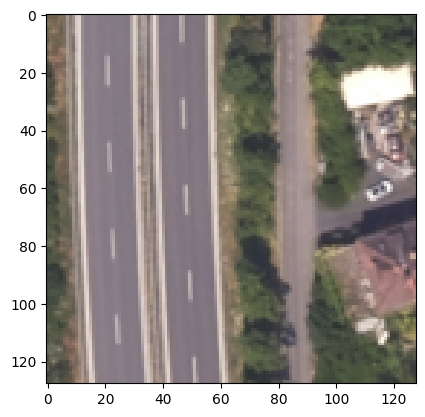

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img_test, interpolation='nearest')
plt.show()

In [ ]:
mask_test = np.load(mask_path)

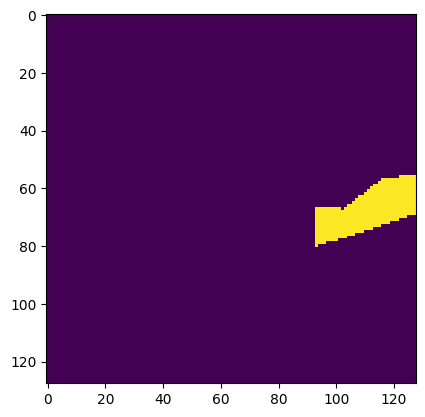

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(mask_test, interpolation='nearest')
plt.show()

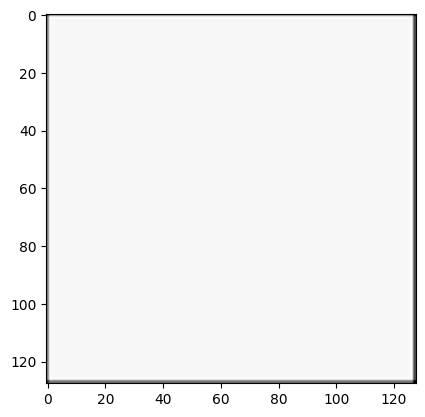

In [ ]:
plt.imshow(pred_ds[i][...,0], cmap = "gray")
plt.show()

### Accuracy and Loss Curve

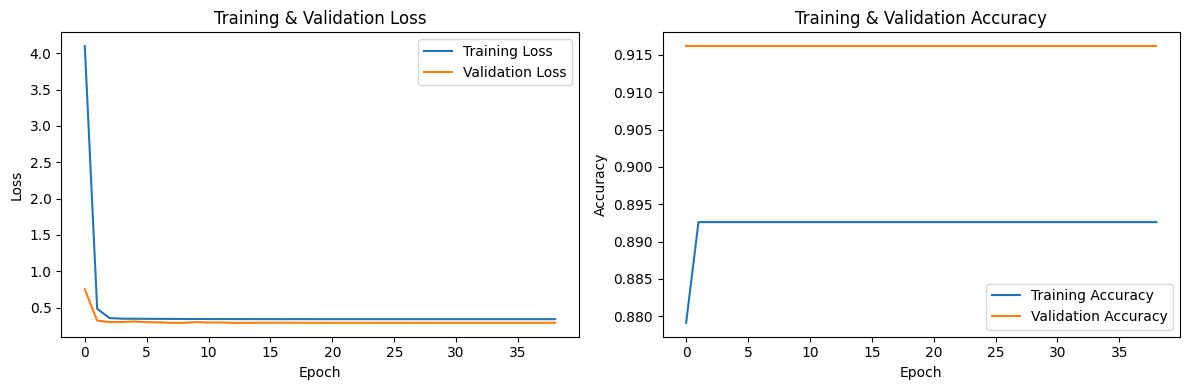

In [ ]:
import matplotlib.pyplot as plt
# import csv logger file
import pandas as pd
#history = pd.read_csv('path to your csv logger')
# Plotting training & validation loss
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### IoU

In [ ]:
# extract the ground truth data
def load_ground_truth_masks(file_names):
    masks = []
    for file in file_names:
        mask = np.load(file)  # Load the ground truth mask file
        mask = np.expand_dims(mask, axis=-1)  # Add an additional dimension if needed
        mask = np.reshape(mask, (128, 128, 1))
        masks.append(mask)  # Append to the list
    return np.array(masks)

ground_truth_masks = load_ground_truth_masks(testing[:,1])

In [ ]:
# Check shape
ground_truth_masks.shape

(1239, 128, 128, 1)

In [ ]:
# Check shape
pred_ds.shape

(1239, 128, 128, 1)

In [ ]:
# overall pixel accuracy -> eventhough does not give us reliable results
def calc_pixel_accuracy(predictions, ground_truths, threshold=0.5):
    # Convert 0-1 values of prediction to binary values
    binary_predictions = (predictions >= threshold).astype(np.int32)

    # Comparison of prediction adn ground truth
    correct_predictions = np.equal(binary_predictions, ground_truths)

    # calcualte accuracy
    accuracy = np.mean(correct_predictions)

    return accuracy

pixel_accuracy = calc_pixel_accuracy(pred_ds, ground_truth_masks)
print(f'Pixel Accuracy: {pixel_accuracy * 100:.2f}%')

Pixel Accuracy: 89.40%


In [ ]:
# IoU
def calc_iou(predictions, ground_truths, threshold=0.5):
    # Binarize predictions
    binary_predictions = (predictions >= threshold).astype(np.int32)

    intersection = np.logical_and(binary_predictions, ground_truths).sum()
    union = np.logical_or(binary_predictions, ground_truths).sum()

    # Compute IoU
    iou = intersection / union if union != 0 else 0.0

    return iou

In [ ]:
iou_score = calc_iou(pred_ds, ground_truth_masks, threshold= 0.1)
print(f'IoU Score: {iou_score:.4f}')

IoU Score: 0.0000


### Precision and Recall

In [ ]:
def calculate_metrics(predictions, ground_truths, threshold=0.5):
    # Binarize predictions
    binary_predictions = (predictions >= threshold).astype(np.int32)

    # Calculate True Positives, False Positives, False Negatives
    TP = np.sum(np.logical_and(binary_predictions == 1, ground_truths == 1))
    FP = np.sum(np.logical_and(binary_predictions == 1, ground_truths == 0))
    FN = np.sum(np.logical_and(binary_predictions == 0, ground_truths == 1))

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

In [ ]:
metrics = calculate_metrics(pred_ds, ground_truth_masks, threshold=0.1)
print(f"Precision: {metrics['Precision']:.4f}")
print(f"Recall: {metrics['Recall']:.4f}")
print(f"F1 Score: {metrics['F1 Score']:.4f}")

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
